<a href="https://colab.research.google.com/github/vifirsanova/compling/blob/main/SMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```Курс "Компьютерная лингвистика" | НИУ ВШЭ Санкт-Петербург
2024 (c) В.И. Фирсанова```

# Tiny SMT

*Обзор*

**Введение (20 минут)**

1. **Компоненты SMT (15 минут)**
   - Определение SMT
   - Компоненты: параллельные корпуса, выравнивание, языковая модель, модель перевода, декодер

2. **Загрузка библиотек (5 минут)**
   - Библиотеки для обработки текстов: NLTK, Spacy
   - Библиотеки для машинного обучения: Scikit-learn

**Tiny SMT (60 минут)**

**1: Препроцессинг (15 минут)**

1. **Паралелльные корпуса (5 минут)**
   - Полезные ресурсы
   - Загрузка датасета EN-DE

2. **Подготовка данных (10 минут)**
   - Чистка данных
   - Токенизация

**2: Модель SMT (20 минут)**

1. **IBM 1 EM (10 минут)**
   - Алгоритм Expectation-Maximization
   - Пишем t-модель с нуля!

2. **LM (10 минут)**
   - Биграммная языковая модель
   - Пишем крошечную LM

**3: Оценка результатов (10 минут)**

1. **BLEU Score (5 минут)**
   - Как считать BLEU
   - Оцениваем нашу модель

2. **Интерпретация результатов (5 минут)**
   - Генерация примеров
   - Интерпретация!

**Домашнее задание:**

- Обучить модель на корпусе EN-RU

# Введение

## Компоненты SMT

**Формальное определение SMT (как это считать --> математика):**
- дано предложение на языке X,
- найти наиболее правдоподобный перевод этого предложения на язык Y:
  - найти такое предложение, которое максимизирует `P(y|x)`, т.е. `argmax P(y|x)`:
    - вычислить допустимые варианты предложений на языке Y путем создания языковой модели `P(y)`;
    - вычислить допустимые пары X - Y путем сопоставления статистических совпадений выравненных фраз в параллельном корпусе `P(x|y)`;
    - максимизировать результат вычисления `P(y) P(x|y)`, т.е. `argmax P(y) P(x|y)`

**Компоненты модели SMT (как это программировать --> код):**

1. ***N-граммная языковая модель*** - моделируем *вероятностное распределение* конструкций на уровне слов или фраз в языке Y
2. ***Модель перевода (t-model)*** - собираем *статистику* соотвествий фраз в паралелльном корпусе, ищем переводческие соответствия X - Y и моделируем их с помощью теории *вероятности*:
  1. Допускаем, что любое предложение языка Y может быть "искаженной" версией некой фразы на языке X
  2. Ищем наиболее правдоподобные соответствия X - Y
3. ***Декодер*** - ищем наиболее грамматичные и лексически правдоподобные результаты, отбираем среди *гипотез* один результат

## Загрузка библиотек

Ваши друзья:

[`sklearn`](https://scikit-learn.org/stable/)

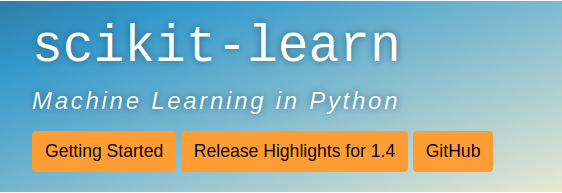

In [ ]:
import tarfile

from sklearn.model_selection import train_test_split

from collections import Counter, defaultdict
import random

# *Tiny* SMT

## 1: Препроцессинг

### Параллельные корпуса

[OPUS](https://opus.nlpl.eu/) Corpora

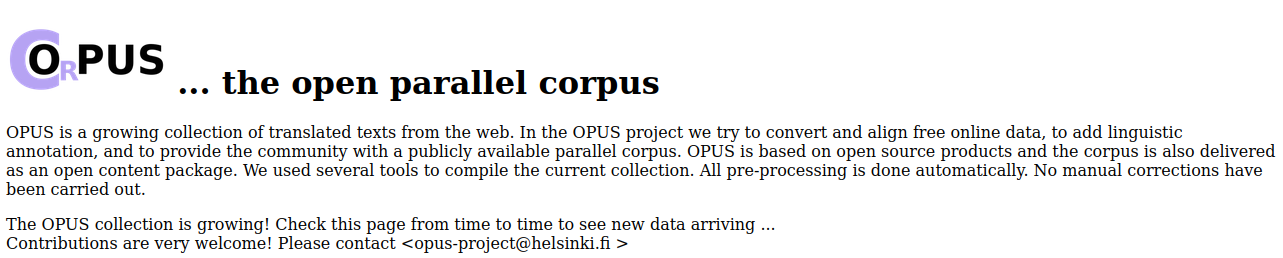

[Kaggle](https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench)

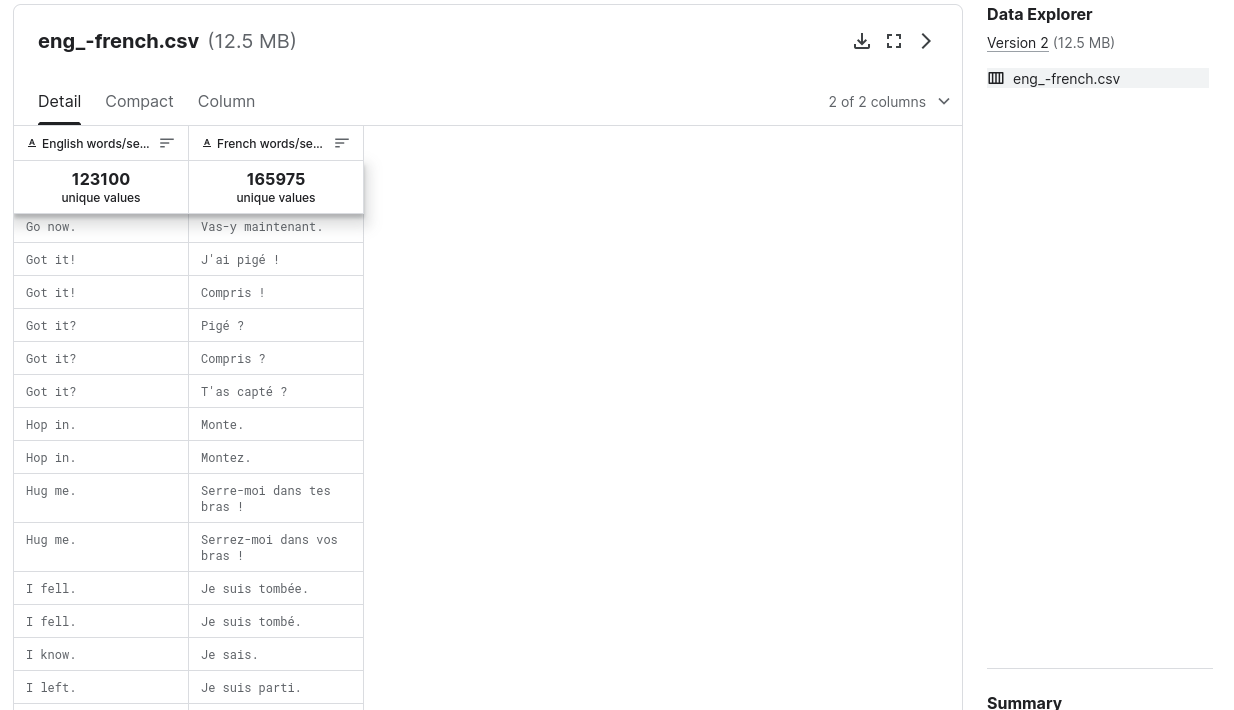

[HuggingFace](https://huggingface.co/datasets?task_categories=task_categories:translation&sort=trending)

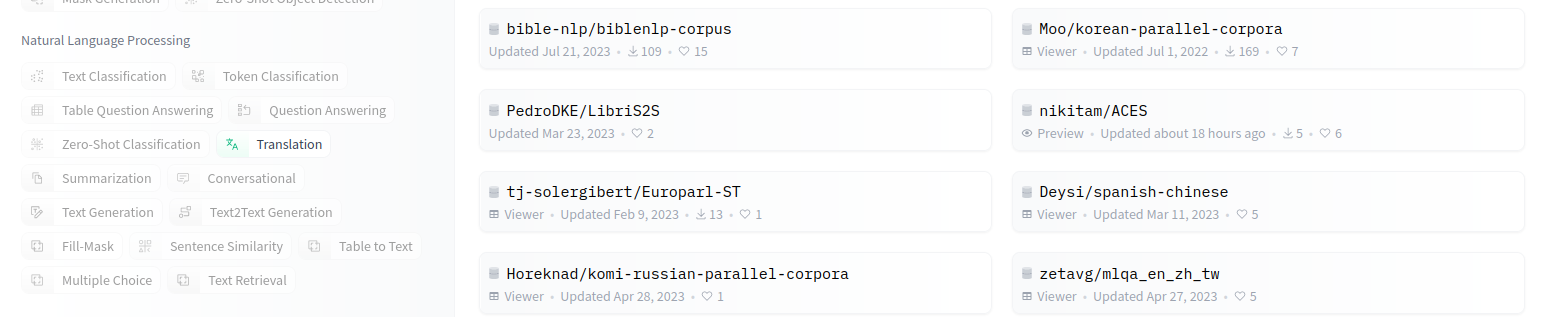

**Задание 1**

Загрузим датасет [Toy 6 short sentences](https://www.cis.lmu.de/~fraser/EMA2008/model1.html)

In [ ]:
# извлекаем файлы из архива
with tarfile.open('toy.tgz', 'r:gz') as tar:
  tar.extractall()

Вызовем команду shell `ls`, чтобы увидеть, что мы распаковали.

In [ ]:
!ls

sample_data  toy.de  toy.en  toy.tgz


Создаем 2 выборки и токенизируем тексты по фразам.

In [ ]:
with open('toy.de', 'r') as f:
  german = f.read().split('\n')[:-1]

with open('toy.en', 'r') as f:
  english = f.read().split('\n')[:-1]

print("Данные языка X:\n", german)
print("Данные языка Y:\n", english)

Данные языка X:
 ['das buch', 'ein haus', 'das grosse buch', 'ein kleines buch', 'das grosse haus', 'ein kleines haus']
Данные языка Y:
 ['the book', 'a house', 'the big book', 'a small book', 'the big house', 'a small house']


Разделим нашу выборку с помощью sklearn.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(english, german)

print("> Обучающая выборка:")
for text, label in zip(X_train, y_train):
    print(f"\nТекст на немецком: {label}\n Его перевод на английский: {text}\n")

print("> Тестовая выборка:")
for text, label in zip(X_test, y_test):
    print(f"\nТекст на немецком: {label}\n Его перевод на английский: {text}\n")

> Обучающая выборка:

Текст на немецком: das grosse haus
 Его перевод на английский: the big house


Текст на немецком: ein haus
 Его перевод на английский: a house


Текст на немецком: ein kleines buch
 Его перевод на английский: a small book


Текст на немецком: ein kleines haus
 Его перевод на английский: a small house

> Тестовая выборка:

Текст на немецком: das buch
 Его перевод на английский: the book


Текст на немецком: das grosse buch
 Его перевод на английский: the big book



### Подготовка данных

На этом этапе вы можете провести чистку данных, выделить би- или триграммы и т.д. Проведем пословную токенизацию каждой фразы.

In [ ]:
def tokenize(sentences):
  # функция возвращает списки слов
  return [sentence.split() for sentence in sentences]

# токенизируем каждую выборку
X_train_tokens, X_test_tokens, y_train_tokens, y_test_tokens = tokenize(X_train), tokenize(X_test), tokenize(y_train), tokenize(y_test)

print('Образец токенизированного текста:', X_train_tokens)

Образец токенизированного текста: [['the', 'big', 'house'], ['a', 'house'], ['a', 'small', 'book'], ['a', 'small', 'house']]


Создадим словарь уникальных словоформ.

In [ ]:
x_vocab = Counter(' '.join(german).split()).keys()
y_vocab = Counter(' '.join(english).split()).keys()

print(f"Словарь немецких словоформ: {x_vocab}\n Всего {len(x_vocab)} словоформ")
print(f"\nCловарь английских словоформ: {y_vocab}\n Всего {len(y_vocab)} словоформ")

Словарь немецких словоформ: dict_keys(['das', 'buch', 'ein', 'haus', 'grosse', 'kleines'])
 Всего 6 словоформ

Cловарь английских словоформ: dict_keys(['the', 'book', 'a', 'house', 'big', 'small'])
 Всего 6 словоформ


## 2: Модель SMT

### IBM 1 Expectation-Maximization (t-model)

In [ ]:
# вероятность того, что случайное слово x_vocab соответсвует случайному слову y_vocab
uniform = 1 / (len(x_vocab) * len(y_vocab))

round(uniform, 3)

0.028

In [ ]:
# t-model
t = {}

for i in range(len(X_train)):
  # начинаем итерацию по обучающей выборке
  for word_x in X_train_tokens[i]:
    for word_y in y_train_tokens[i]:
      # создаем t-table
      t[(word_x, word_y)] = uniform

# t-table
for elem in t:
  print("Соответствие |", elem[0], "  ->  ", elem[1], "| Вероятность:", round(t[elem], 3))

Соответствие | the   ->   das | Вероятность: 0.028
Соответствие | the   ->   grosse | Вероятность: 0.028
Соответствие | the   ->   haus | Вероятность: 0.028
Соответствие | big   ->   das | Вероятность: 0.028
Соответствие | big   ->   grosse | Вероятность: 0.028
Соответствие | big   ->   haus | Вероятность: 0.028
Соответствие | house   ->   das | Вероятность: 0.028
Соответствие | house   ->   grosse | Вероятность: 0.028
Соответствие | house   ->   haus | Вероятность: 0.028
Соответствие | a   ->   ein | Вероятность: 0.028
Соответствие | a   ->   haus | Вероятность: 0.028
Соответствие | house   ->   ein | Вероятность: 0.028
Соответствие | a   ->   kleines | Вероятность: 0.028
Соответствие | a   ->   buch | Вероятность: 0.028
Соответствие | small   ->   ein | Вероятность: 0.028
Соответствие | small   ->   kleines | Вероятность: 0.028
Соответствие | small   ->   buch | Вероятность: 0.028
Соответствие | book   ->   ein | Вероятность: 0.028
Соответствие | book   ->   kleines | Вероятность: 0.

In [ ]:
# количество итераций обучения
epochs = 7

In [ ]:
for epoch in range(epochs):
  # начинаем обучение

  # шаг 0. создаем слоты для подсчета статистики
  count = {} # P(x|y)
  total = {} # P(y)

  for i in range(len(X_train)):
    # начинаем итерацию по обучающей выборке
    for word_x in X_train_tokens[i]:
      for word_y in y_train_tokens[i]:
        # создаем слоты для подсчета условной вероятности совпадений в корпусе
        count[(word_x, word_y)] = 0
        # и слоты для статистической языковой модели y
        total[word_y] = 0

  # шаг 1. Expectation
  for i in range(len(X_train)):
    # начинаем итерацию по обучающей выборке
    total_stat = {} # статистика x

    # собираем предварительную статистику на основе данных x
    for word_x in X_train_tokens[i]:
      total_stat[word_x] = 0 # создаем слоты для подсчета статистики по каждому токену x
      for word_y in y_train_tokens[i]:
        # обновляем данные из t-table; увеличиваем значения при обнаружении совместной встречаемости
        total_stat[word_x] += t[(word_x, word_y)]

    # обновляем данные для P(x|y) и P(y)
    for word_x in X_train_tokens[i]:
      for word_y in y_train_tokens[i]:
        # подсчет условной вероятности совпадений в корпусе: равномерное распределение / частотность x
        count[(word_x, word_y)] += t[(word_x, word_y)] / total_stat[word_x]
        # подсчет статистической информации y: равномерное распределение / частотность x
        total[word_y] += t[(word_x, word_y)] / total_stat[word_x]

  # шаг 2. Maximization
  for i in range(len(X_train)):
    # начинаем итерацию по обучающей выборке
    for word_x in X_train_tokens[i]:
      for word_y in y_train_tokens[i]:
        # обновляем t-table: вероятность совпадения в корпусе / вероятность информации y
        t[(word_x, word_y)] = count[(word_x, word_y)] / total[word_y]

for elem in t:
  print("Соответствие |", elem[0], "  ->  ", elem[1], "| Вероятность:", round(t[elem], 3))

Соответствие | the   ->   das | Вероятность: 0.455
Соответствие | the   ->   grosse | Вероятность: 0.455
Соответствие | the   ->   haus | Вероятность: 0.001
Соответствие | big   ->   das | Вероятность: 0.455
Соответствие | big   ->   grosse | Вероятность: 0.455
Соответствие | big   ->   haus | Вероятность: 0.001
Соответствие | house   ->   das | Вероятность: 0.089
Соответствие | house   ->   grosse | Вероятность: 0.089
Соответствие | house   ->   haus | Вероятность: 0.92
Соответствие | a   ->   ein | Вероятность: 0.837
Соответствие | a   ->   haus | Вероятность: 0.076
Соответствие | house   ->   ein | Вероятность: 0.075
Соответствие | a   ->   kleines | Вероятность: 0.195
Соответствие | a   ->   buch | Вероятность: 0.067
Соответствие | small   ->   ein | Вероятность: 0.086
Соответствие | small   ->   kleines | Вероятность: 0.783
Соответствие | small   ->   buch | Вероятность: 0.124
Соответствие | book   ->   ein | Вероятность: 0.002
Соответствие | book   ->   kleines | Вероятность: 0.0

### Биграммная модель

In [ ]:
# для обучения модели объединим 2 выборки
tokens = ' '.join(german).split()

# хранилище для биграмм
bigram_model = defaultdict(list)

# собираем все попарные совпадения
for i in range(len(tokens)-1):
    current_word = tokens[i]
    next_word = tokens[i + 1]
    bigram_model[current_word].append(next_word)

print(bigram_model)

def decoder(model, steps=5):
  # инициализация случайного токена
  current_word = random.choice(tokens)
  generated_sentence = current_word

  for step in range(steps):
    # пошаговая генерация
    print('Шаг', step+1)
    next_word_options = model[current_word]
    print(f'Правдоподобные варианты продолжения для токена {current_word}:', next_word_options)

    current_word = random.choice(next_word_options)
    generated_sentence += ' '
    generated_sentence += current_word
    print('Промежуточный результат:', generated_sentence)
    print()
  print('Результат:', generated_sentence)

decoder(bigram_model)

defaultdict(<class 'list'>, {'das': ['buch', 'grosse', 'grosse'], 'buch': ['ein', 'ein', 'das'], 'ein': ['haus', 'kleines', 'kleines'], 'haus': ['das', 'ein'], 'grosse': ['buch', 'haus'], 'kleines': ['buch', 'haus']})
Шаг 1
Правдоподобные варианты продолжения для токена ein: ['haus', 'kleines', 'kleines']
Промежуточный результат: ein kleines

Шаг 2
Правдоподобные варианты продолжения для токена kleines: ['buch', 'haus']
Промежуточный результат: ein kleines haus

Шаг 3
Правдоподобные варианты продолжения для токена haus: ['das', 'ein']
Промежуточный результат: ein kleines haus das

Шаг 4
Правдоподобные варианты продолжения для токена das: ['buch', 'grosse', 'grosse']
Промежуточный результат: ein kleines haus das buch

Шаг 5
Правдоподобные варианты продолжения для токена buch: ['ein', 'ein', 'das']
Промежуточный результат: ein kleines haus das buch ein

Результат: ein kleines haus das buch ein


## 3: Оценка результатов

[NLTK Translate](https://www.nltk.org/api/nltk.translate.bleu_score.html)

In [ ]:
# сортировка t-table по убыванию правдоподобия
sorted_t = sorted(t.items(), key = lambda k:(k[1], k[0]), reverse = True)

def translate(token):
  for element in sorted_t:
    if element[0][1] == token:
      # поиск совпадений в t-table
      return element[0][0]

for sentence in y_test_tokens:
  print("Оригинальное предложение:", ' '.join(sentence))
  translation = []
  for token in sentence:
    translation.append(translate(token))
  print("Перевод:", ' '.join(translation))

Оригинальное предложение: das buch
Перевод: the book
Оригинальное предложение: das grosse buch
Перевод: the the book


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

reference = [X_test_tokens[0], X_test_tokens[1]]
candidate = [translate(token) for token in y_test_tokens[0]]

bleu_score = corpus_bleu(reference, candidate)

print("BLEU Score:", bleu_score)

BLEU Score: 0.8408964152537145


In [ ]:
reference

[['the', 'book'], ['the', 'big', 'book']]

In [ ]:
candidate

['the', 'book']

Что почитать? Учебник "Statistical Machine Translation", Philipp Koehn

Домашнее задание:

1. Повторить проведенный эксперимент на любом другом корпусе на выбор из туториала https://www.cis.lmu.de/~fraser/EMA2008/model1.html (по желанию)
2. Своими словами описать принцип работы SMT (основные компоненты, важную терминологию) - сделайте это в формате конспекта-шпаргалки, к которой вы сможете вернуться в будущем (обязательно)